In [2]:
#Importing libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.utils.layer_utils import count_params



#Loading data, training data is 60,000 28x28 grayscale images, labeled with an integer 0-9.
# Test data is 10,000 image-label pairs.
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

label_names = ['T-shirt/Top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']



2024-10-10 08:23:51.885679: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


We wish to build an 80/10/10 train/dev/test split. So first we merge the data together so we can shuffle it uniformly. 

In [3]:
# Merges N obersvations of 28x28 image and label data into flattened Nx785 array
# Because 785 = 28*28 + 1
def merge_images_labels(images, labels):
    images_flat = images.reshape((images.shape[0], -1))
    labels_transposed = labels.reshape((-1, 1))
    merged = np.concatenate([images_flat, labels_transposed], axis=1)
    return merged


# Merges images and labels for train and test data
train_data = merge_images_labels(x_train, y_train)
test_data = merge_images_labels(x_test, y_test)

#Merging train and test data together, then shuffling
full_data = np.concatenate([train_data, test_data], axis=0)
full_data_shuffled = tf.random.shuffle(full_data)

dataset_size = full_data_shuffled.shape[0]

num_train = int(0.8* dataset_size)
num_dev = int(0.1* dataset_size)
num_test = dataset_size - (num_train + num_dev)

print('Training size: ', num_train)
print('Dev size: ', num_dev)
print('Test size: ', num_test)

#Splitting our shuffled data into train, dev, and test sets
train_data = full_data_shuffled[:num_train]
dev_data = full_data_shuffled[num_train : num_train + num_dev]
test_data = full_data_shuffled[-num_test : ]

Training size:  56000
Dev size:  7000
Test size:  7000


Now that our data is split into train, dev, and test sets, we separate the image and label pairs again.

In [4]:

def split_images_labels(data):
    images = data[:, :-1]
    labels = data[:, -1]
    return images, labels

x_train, y_train = split_images_labels(train_data)
x_test, y_test = split_images_labels(test_data)
x_dev, y_dev = split_images_labels(dev_data)

To set a basepoint for our analysis, we investigate the performance and model size of logistic regression with this dataset. 

In [5]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()
logistic_regression = tf.keras.models.Sequential([tf.keras.layers.Dense(10)], name='logistic_regression')
logistic_regression.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])
logistic_history = logistic_regression.fit(x_train, y_train, epochs=10, validation_data = (x_dev, y_dev))
logistic_regression.summary()


Epoch 1/10
1750/1750 [==============================] - 5s 3ms/step - loss: 0.6119 - accuracy: 0.7931 - val_loss: 0.4878 - val_accuracy: 0.8350
Epoch 2/10
1750/1750 [==============================] - 4s 2ms/step - loss: 0.4679 - accuracy: 0.8398 - val_loss: 0.4454 - val_accuracy: 0.8451
Epoch 3/10
1750/1750 [==============================] - 3s 2ms/step - loss: 0.4409 - accuracy: 0.8490 - val_loss: 0.4282 - val_accuracy: 0.8509
Epoch 4/10
1750/1750 [==============================] - 5s 3ms/step - loss: 0.4292 - accuracy: 0.8520 - val_loss: 0.4271 - val_accuracy: 0.8516
Epoch 5/10
1750/1750 [==============================] - 3s 2ms/step - loss: 0.4185 - accuracy: 0.8544 - val_loss: 0.4163 - val_accuracy: 0.8530
Epoch 6/10
1750/1750 [==============================] - 4s 2ms/step - loss: 0.4115 - accuracy: 0.8571 - val_loss: 0.4173 - val_accuracy: 0.8544
Epoch 7/10
1750/1750 [==============================] - 5s 3ms/step - loss: 0.4069 - accuracy: 0.8592 - val_loss: 0.4094 - val_accuracy:

We want some general tools for evaluating models. Namely we want to be able to graph their accuracy over training, and we want to compute their total number of trainable parameters. So we build general purpose functions for doing each of these tasks.

In [6]:
def total_trainable_parameters(model : tf.keras.Model):
    return sum(layer.count_params() for layer in model.layers)

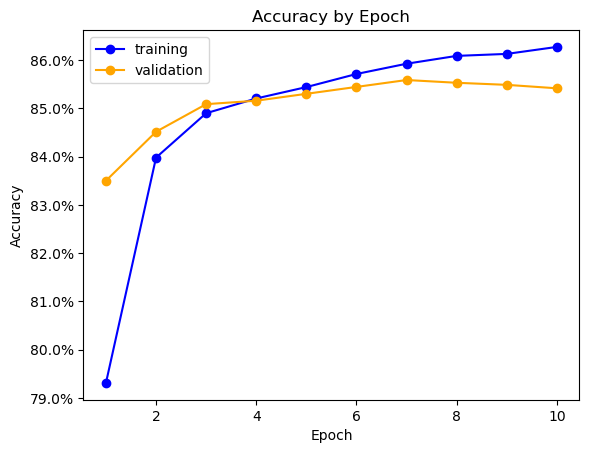

In [7]:
# Generates a matplotlib figure, axis object plotting the result of a model fit's history object
# INPUT: history -- tf.keras.callbacks.History object, expects accuracy metric results.
# RETURN: Figure, Axis -- Matplotlib object plotting training and validation accuracy by epoch
# EXCEPTION: TypeError if Input not a history object
def plot_training_history(history : tf.keras.callbacks.History):
    history_dict = history.history
    fig, ax = plt.subplots()
    num_epochs = len(history_dict['accuracy'])
    x_values = np.arange(1, num_epochs + 1)
    ax.plot(x_values, history_dict['accuracy'], marker='o', color='blue', label='training')
    if 'val_accuracy' in history_dict:
        ax.plot(x_values, history_dict['val_accuracy'], marker='o', color='orange', label='validation')
        ax.legend()
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.set_title('Accuracy by Epoch')
    ax.yaxis.set_major_formatter(lambda x, y : str(100*round(x, 3)) + '%')
    return fig, ax
    
fig, ax = plot_training_history(logistic_history)
plt.show()

It looks like logistic regression plateaus at around 85% accuracy, so that is our benchmark for further methods.

In [18]:

dense_model = tf.keras.models.Sequential([tf.keras.layers.Dense(128, activation='relu'),
                                               tf.keras.layers.Dense(64, activation='relu'),
                                               tf.keras.layers.Dense(32, activation='relu'),

                                               tf.keras.layers.Dense(10)])

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, ema_momentum=True)
dense_model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])
dense_model_history = dense_model.fit(x_train, y_train, epochs=10, validation_data=(x_dev, y_dev))

Epoch 1/10
1750/1750 [==============================] - 12s 6ms/step - loss: 0.5256 - accuracy: 0.8155 - val_loss: 0.4059 - val_accuracy: 0.8563
Epoch 2/10
1750/1750 [==============================] - 14s 8ms/step - loss: 0.3796 - accuracy: 0.8616 - val_loss: 0.3340 - val_accuracy: 0.8780
Epoch 3/10
1750/1750 [==============================] - 10s 6ms/step - loss: 0.3435 - accuracy: 0.8747 - val_loss: 0.4318 - val_accuracy: 0.8409
Epoch 4/10
1750/1750 [==============================] - 7s 4ms/step - loss: 0.3229 - accuracy: 0.8807 - val_loss: 0.3244 - val_accuracy: 0.8774
Epoch 5/10
1750/1750 [==============================] - 7s 4ms/step - loss: 0.3057 - accuracy: 0.8866 - val_loss: 0.3174 - val_accuracy: 0.8837
Epoch 6/10
1750/1750 [==============================] - 10s 5ms/step - loss: 0.2898 - accuracy: 0.8928 - val_loss: 0.3079 - val_accuracy: 0.8870
Epoch 7/10
1750/1750 [==============================] - 8s 5ms/step - loss: 0.2767 - accuracy: 0.8970 - val_loss: 0.3124 - val_accur

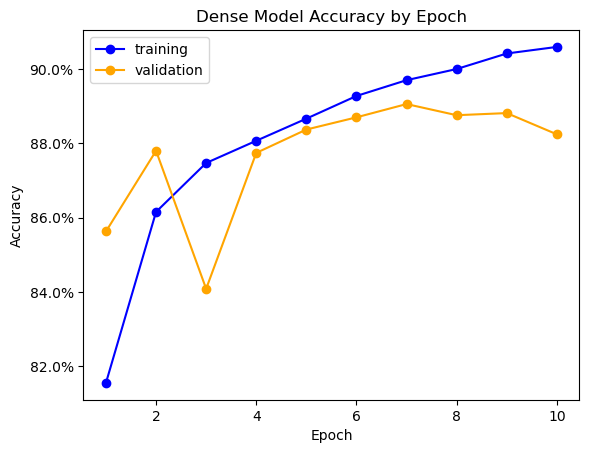

The dense model has  111146  total parameters


In [19]:
fig, ax = plot_training_history(dense_model_history)
ax.set_title('Dense Model Accuracy by Epoch')
plt.show()

print('The dense model has ', total_trainable_parameters(dense_model), ' total parameters')

This model looks to plateau at around 88% accuracy at the cost of ~100K parameters, significantly more than the logistic regression model. We try a convolutional model and aim to get similar results with fewer parameters.

In [30]:
#Building a convolutional neural network

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001, ema_momentum=True)
regularizer = tf.keras.regularizers.L1(0.01)

layers = [tf.keras.layers.Reshape((28, 28, 1), input_shape=(784, )), 
          tf.keras.layers.Conv2D(8, (3, 3), padding='same', activation='relu'),
          tf.keras.layers.MaxPool2D((2, 2)),
          tf.keras.layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
          tf.keras.layers.MaxPool2D((2, 2)),
          tf.keras.layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(64, activation='relu', activity_regularizer=regularizer),
          tf.keras.layers.Dense(10)]

convolutional_model = tf.keras.models.Sequential(layers)


convolutional_model.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])
convolutional_model.summary()



Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_2 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 8)         80        
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 8)        0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 16)        1168      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 7, 7, 16)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 7, 7, 16)        

In [31]:
convolutional_history = convolutional_model.fit(x_train, y_train, epochs=10, validation_data=(x_dev, y_dev))

Epoch 1/10
1750/1750 [==============================] - 38s 20ms/step - loss: 0.6485 - accuracy: 0.8219 - val_loss: 0.4703 - val_accuracy: 0.8653
Epoch 2/10
1750/1750 [==============================] - 34s 19ms/step - loss: 0.4233 - accuracy: 0.8795 - val_loss: 0.3896 - val_accuracy: 0.8893
Epoch 3/10
1750/1750 [==============================] - 22s 13ms/step - loss: 0.3606 - accuracy: 0.8965 - val_loss: 0.3455 - val_accuracy: 0.8976
Epoch 4/10
1750/1750 [==============================] - 24s 14ms/step - loss: 0.3240 - accuracy: 0.9051 - val_loss: 0.3242 - val_accuracy: 0.9024
Epoch 5/10
1750/1750 [==============================] - 27s 15ms/step - loss: 0.2979 - accuracy: 0.9113 - val_loss: 0.3040 - val_accuracy: 0.9070
Epoch 6/10
1750/1750 [==============================] - 28s 16ms/step - loss: 0.2760 - accuracy: 0.9187 - val_loss: 0.3050 - val_accuracy: 0.9070
Epoch 7/10
1750/1750 [==============================] - 28s 16ms/step - loss: 0.2590 - accuracy: 0.9230 - val_loss: 0.2984 -

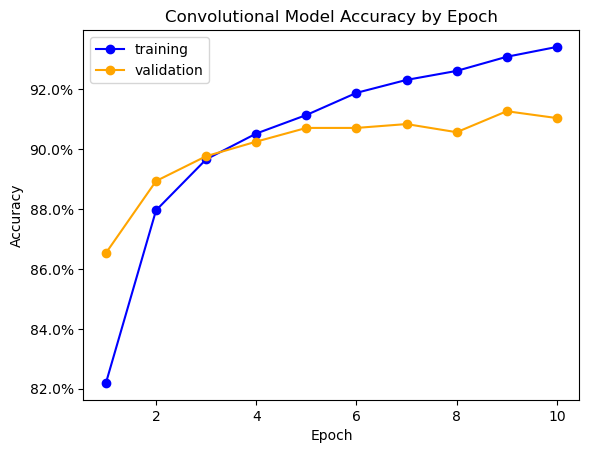

In [34]:
fig, ax = plot_training_history(convolutional_history)
ax.set_title('Convolutional Model Accuracy by Epoch')
plt.show()

Now for the moment of truth! We evaluate each model on the test set, which at this point we have not used in the development process.

In [36]:
print('Logistic regression test:')
logistic_regression.evaluate(x_test, y_test)
print()
print('Dense model test:')
dense_model.evaluate(x_test, y_test)
print()
print('Convolutional model test:')
convolutional_model_accuracy = convolutional_model.evaluate(x_test, y_test)[1]

Logistic regression test:
219/219 [==============================] - 0s 1ms/step - loss: 0.4248 - accuracy: 0.8546

Dense model test:
219/219 [==============================] - 1s 2ms/step - loss: 0.3447 - accuracy: 0.8839

Convolutional model test:
219/219 [==============================] - 1s 5ms/step - loss: 0.2906 - accuracy: 0.9113


So logistic regression predicts at 85% accuracy with ~7K parameters 
the dense model predicts at 88% accuracy with ~110K parameters
and the convolutional model predicts at 91% accuracy with ~55K parameters.

In [71]:
# Saving the models to .keras files.
logistic_regression.save('logistic_regression.keras')
dense_model.save('dense_model.keras')
convolutional_model.save('convolutional_model.keras')

Now let's use our model to actually do some predictions on the test set. We present some sample images, 
together with their ground truth labels, the predicted labels generated by the model,
as well as the probabilities the model assigns to all possible labels. 

1/1 [==============================] - 0s 100ms/step


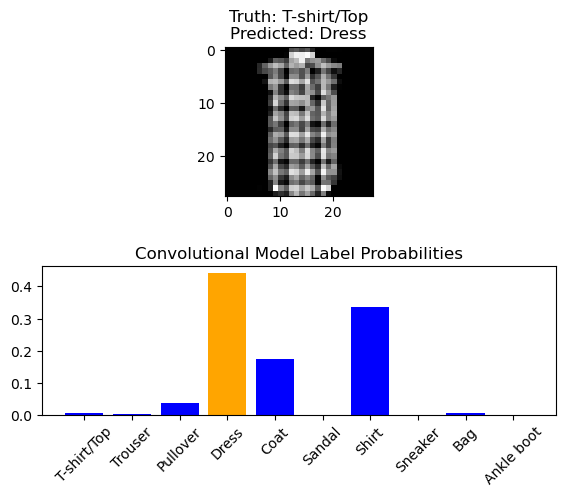

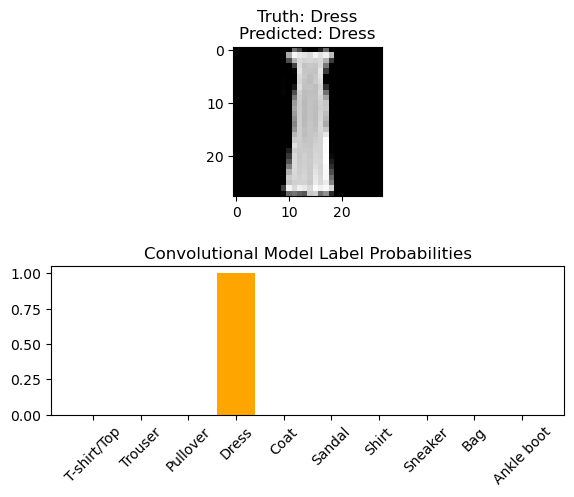

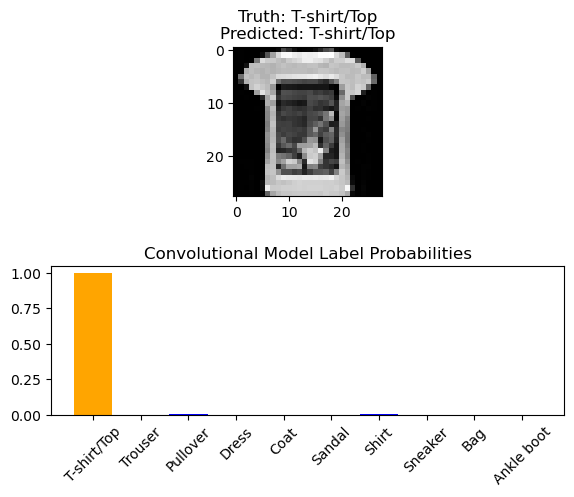

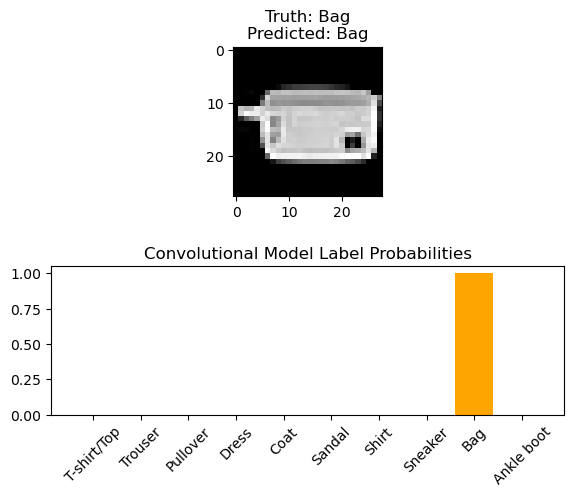

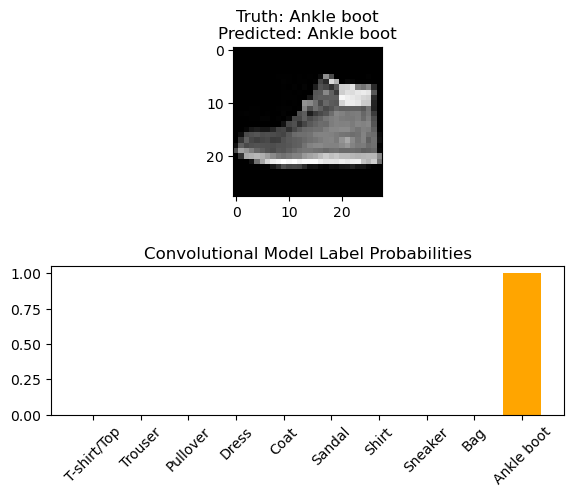

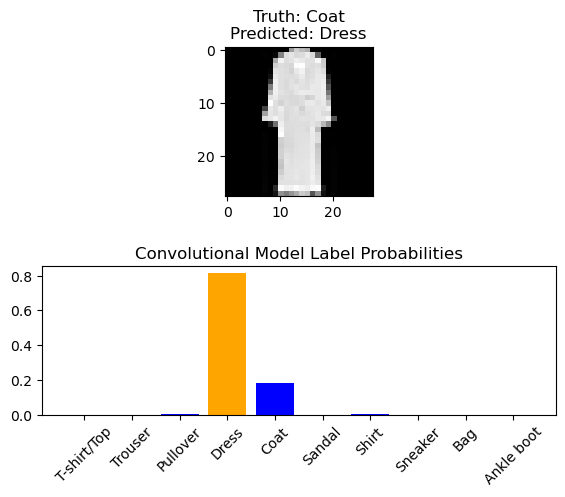

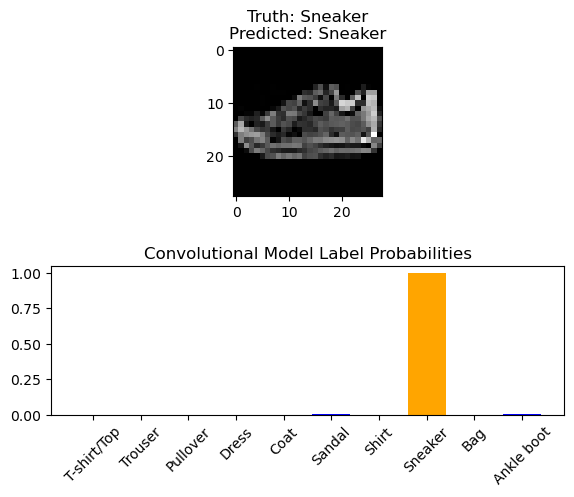

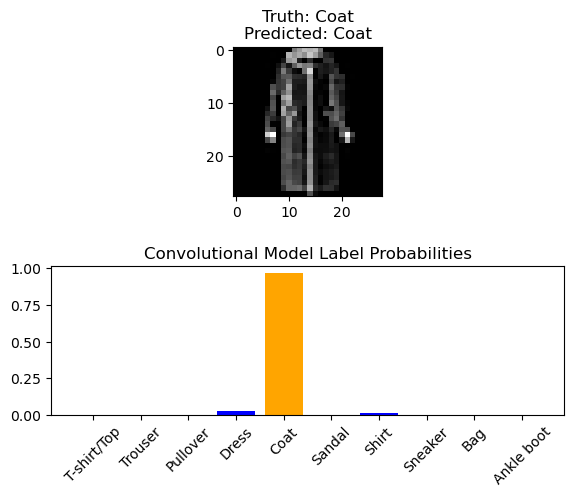

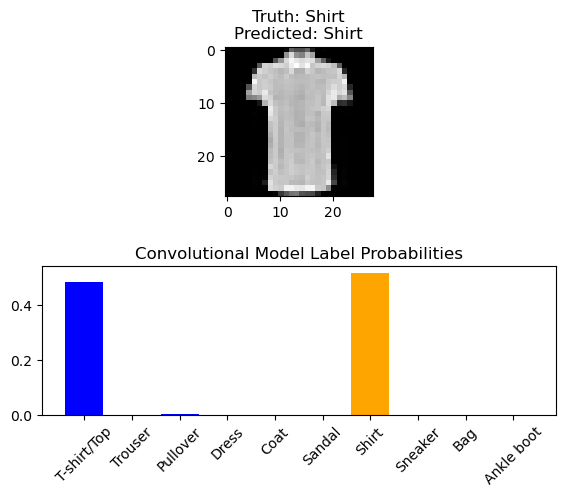

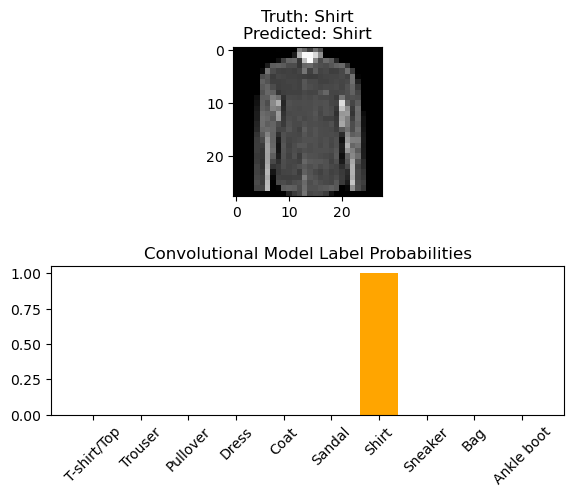

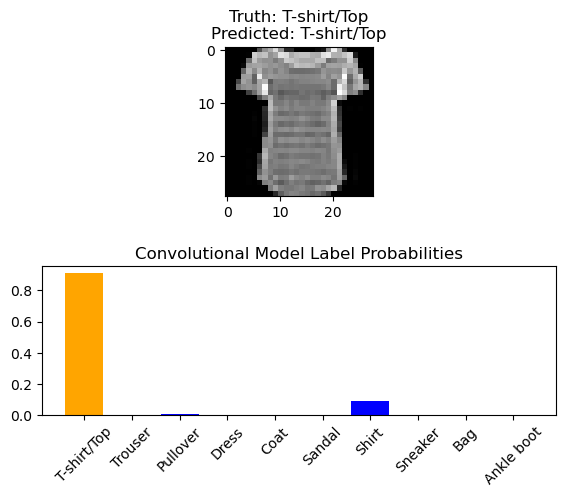

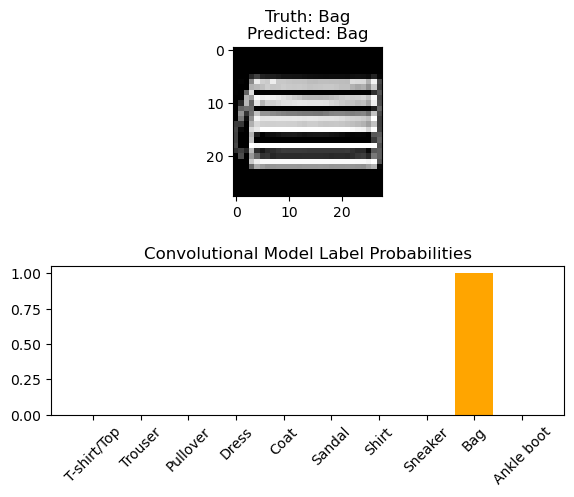

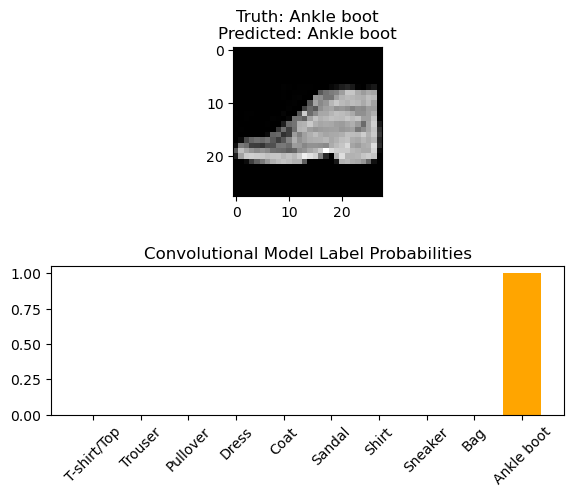

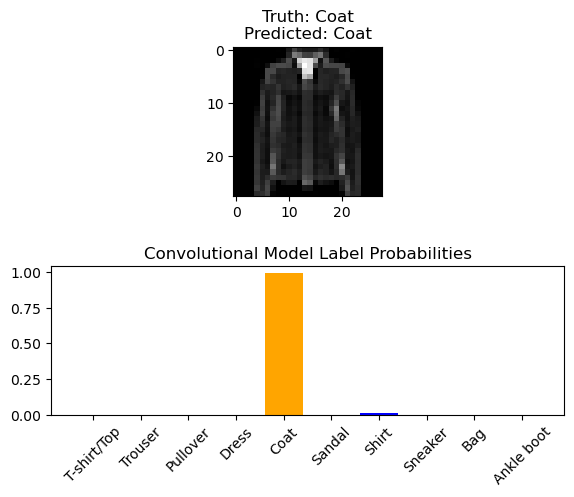

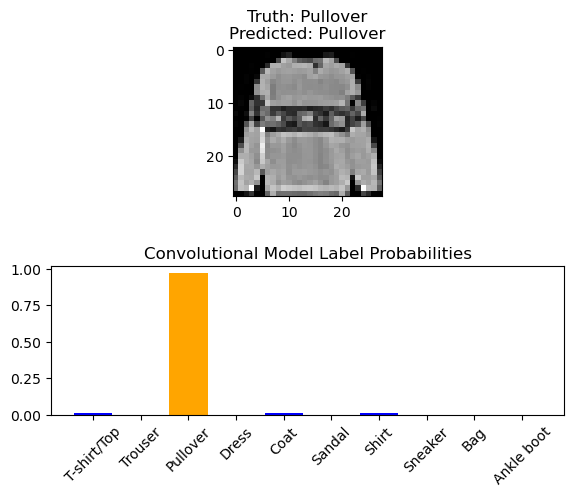

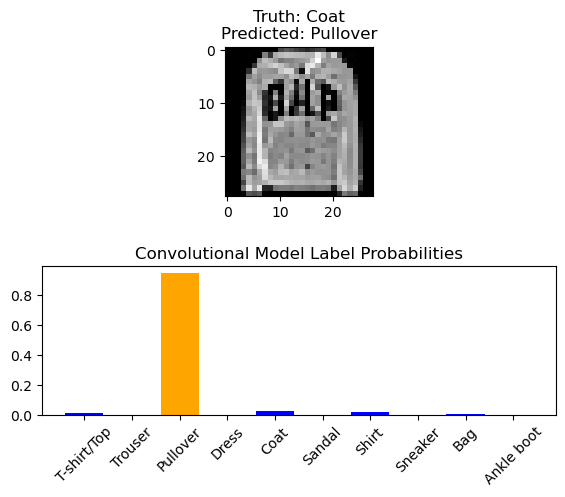

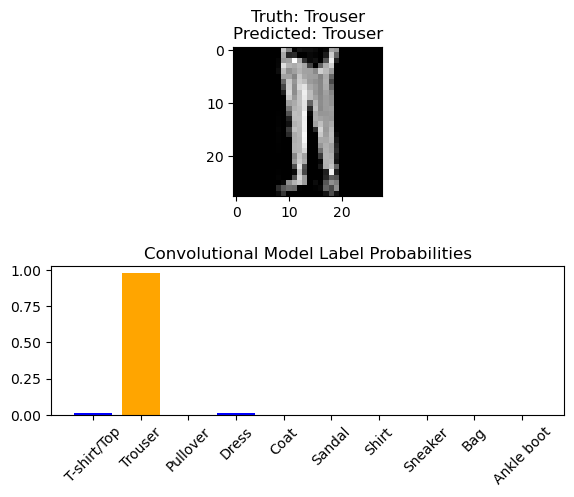

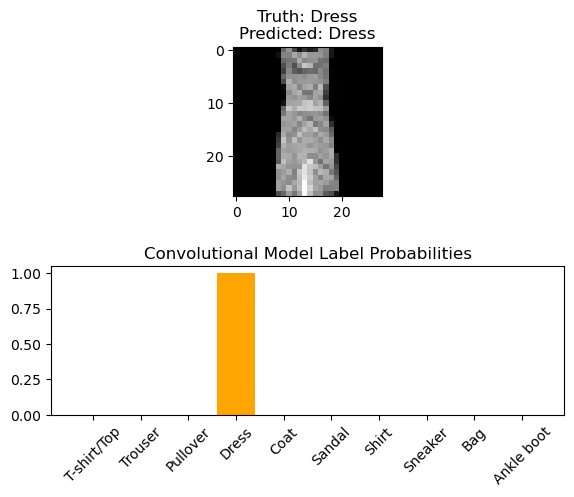

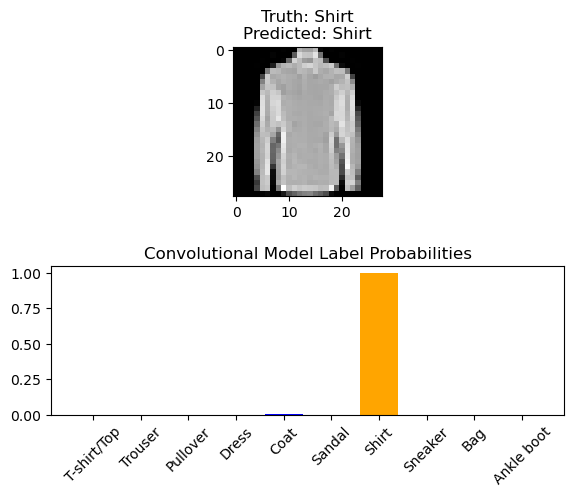

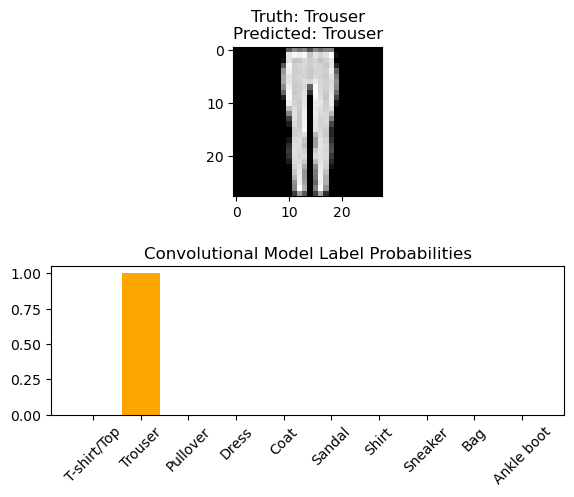

In [102]:
N = 20
import copy

convolutional_predictor = tf.keras.models.Sequential([convolutional_model, tf.keras.layers.Softmax()])

predictions = convolutional_predictor.predict(x_test[:N])

true_label_indices = np.array(y_test[:N], dtype=int)
true_labels = [label_names[true_label_index] for true_label_index in true_label_indices]

images = np.reshape(x_test[:N], (-1, 28, 28))

default_colors = ['blue' for i in range(10)]

for prediciton, image, true_label in zip(predictions, images, true_labels):
    fig, ax = plt.subplots(2)
    fig.tight_layout(pad=3)
    ax[0].imshow(image, 'gray')
    predicted_index = np.argmax(prediciton)
    predicted_name = label_names[predicted_index]
    ax[0].set_title('Truth: ' + true_label + '\nPredicted: ' + predicted_name)
    bar_colors = copy.copy(default_colors)
    bar_colors[predicted_index] = 'orange'
    ax[1].bar(label_names, prediciton, color=bar_colors)
    ax[1].xaxis.set_tick_params(rotation=45)
    ax[1].set_title('Convolutional Model Label Probabilities')
    plt.show()